In [1]:
!pip install sentence-transformers

In [23]:
!pip install transformers torch pandas

In [51]:
!pip install nltk


   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 8.8 MB/s eta 0:00:00


In [54]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import json
from transformers import AutoTokenizer, AutoModel
import torch
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = list(stopwords.words('english'))

model = SentenceTransformer('all-MiniLM-L6-v2') 
filename = os.path.join(os.getcwd(), "data", "description_extracted.csv")
df = pd.read_csv(filename, header=0)
df.dropna(inplace=True)
df.isna().sum()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mihil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


RequisitionID           0
ExtractedDescription    0
dtype: int64

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=300, stop_words=stop_words)  # Adjust feature limit if needed
tfidf_matrix = vectorizer.fit_transform(df['ExtractedDescription'])
df['DescriptionEmbedding'] = list(tfidf_matrix.toarray())

In [57]:
#df[['RequisitionID', 'DescriptionEmbedding']].to_csv('data/job_descriptions_with_embeddings.csv', index=False)

In [58]:
from sklearn.cluster import KMeans

num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

df['cluster'] = kmeans.fit_predict(list(df['DescriptionEmbedding']))


In [63]:
from sklearn.decomposition import PCA

# Reduce dimensions to 2 for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(tfidf_matrix.toarray())

# Create a DataFrame with the reduced data
reduced_df = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
reduced_df['cluster'] = df['cluster']
reduced_df.head()

,PC1,PC2,cluster
0,0.040802,-0.083800,NaN
1,0.096632,-0.050560,4.0
2,-0.067783,-0.137788,0.0
3,-0.034837,-0.045757,4.0
4,0.064347,-0.085221,4.0


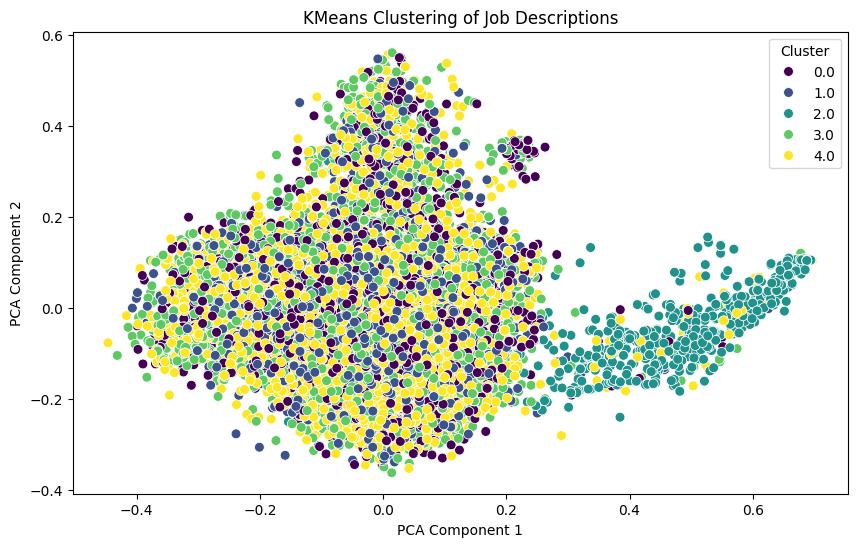

In [65]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=reduced_df, x='PC1', y='PC2', hue='cluster', palette='viridis', s=50)
plt.title('KMeans Clustering of Job Descriptions')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()


In [68]:
def suggest_job_title(cluster_df):
    common_terms = cluster_df['ExtractedDescription'].str.cat(sep=' ')
    words = common_terms.split()
    common_words = pd.Series(words).value_counts().head(5)  # Get the top 5 words
    title = ' '.join(common_words.index)  # Form a title from common words
    return title

# Generate job titles for each cluster
job_titles = {}
for cluster in range(5):
    cluster_data = df[df['cluster'] == cluster]
    job_titles[cluster] = suggest_job_title(cluster_data)

# Display the suggested job titles
for cluster, title in job_titles.items():
    print(f'Cluster {cluster}: Suggested Job Title: "{title}"')


C:\Users\mihil\AppData\Local\Temp\ipykernel_18032\1905627421.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cluster_data = df[reduced_df['cluster'] == cluster]


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).